In [1]:
print("Emotion classification")

Emotion classification


In [2]:
import pandas as pd
import numpy as np
import pickle
from nltk.stem import PorterStemmer
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder 

In [3]:
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [4]:
train_data=pd.read_csv("dataset/train.txt", sep=";", header=None, names=["Comment", "Emotion"], encoding="utf-8")
train_data.head()

,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
train_data['length']=[len(x) for x in train_data['Comment']]
train_data.tail()

,Comment,Emotion,length
15995,i just had a very brief time in the beanbag an...,sadness,101
15996,i am now turning and i feel pathetic that i am...,sadness,102
15997,i feel strong and good overall,joy,30
15998,i feel like this was such a rude comment and i...,anger,59
15999,i know a lot but i feel so stupid because i ca...,sadness,62


In [6]:
train_data.shape

(16000, 3)

In [7]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [8]:
print(train_data.duplicated().sum())

1


#### **EDA**

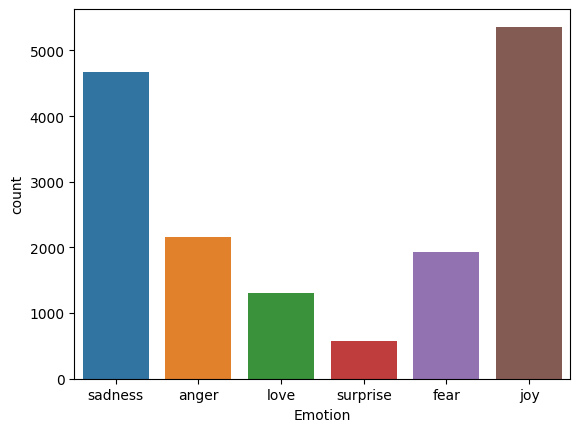

In [9]:
sns.countplot(x=train_data['Emotion'],hue=train_data['Emotion'])
plt.show()

Text(0, 0.5, 'Count')

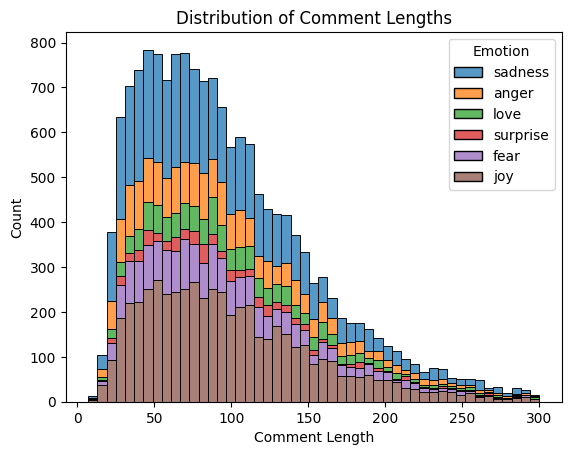

In [10]:
df2=train_data.copy()
df2['length']=[len(x) for x in train_data['Comment']]
length_value=df2['length'].values
sns.histplot(data=df2, x='length', hue=df2['Emotion'], multiple='stack')
plt.title('Distribution of Comment Lengths')
plt.xlabel('Comment Length')
plt.ylabel('Count')

In [11]:
emotions_list = train_data['Emotion'].unique()
emotions_list

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [12]:
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10,10))
    plt.title(df + 'wordcloud', size=15)
    plt.imshow(wordcloud)
    plt.axis("off")


# emotions_list=train_data['Emotion'].unique()
# for emotion in emotions_list:
#     text=''.join([sentence for sentence in train_data.loc[train_data['Emotion']==emotion, 'Comment']])
#     wordcloud=WordCloud(width=600, height=600).generate(text)
#     words_cloud(wordcloud, emotion)

In [13]:
#Data preprocessing

In [14]:
lb=LabelEncoder()
train_data['Emotion']=lb.fit_transform(train_data['Emotion'])
train_data.sample(5)

,Comment,Emotion,length
3020,i wanted to really love this book social thoug...,4,139
12830,i feel like i am supporting her party,2,37
8334,im thinking about death at the moment and feel...,4,99
9207,i hope the two of you don t feel it was all in...,4,51
6730,i can t stand it i feel like hes spying on me ...,2,123


In [15]:
from sklearn.model_selection import  train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [16]:
df=train_data.copy()
df.head()

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20


In [17]:
import nltk
import re

In [18]:
from tqdm import tqdm
tqdm.pandas()
nltk.download('stopwords')
stopwords=set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
from tqdm import tqdm
tqdm.pandas()
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

def clean_data(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]", " ",text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_comment']  = df['Comment'].progress_apply(clean_data)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 16000/16000 [00:01<00:00, 9591.17it/s]


In [26]:
df.head()

,Comment,Emotion,length,cleaned_comment
0,i didnt feel humiliated,4,23,didnt feel humili
1,i can go from feeling so hopeless to so damned...,4,108,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,0,48,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,3,92,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,0,20,feel grouchi


In [36]:
x_train, x_test, y_train, y_test=train_test_split(df['cleaned_comment'], df['Emotion'], test_size=0.2, random_state=42)


In [37]:
ifidfvectorizer=TfidfVectorizer()
x_train_tfidf = ifidfvectorizer.fit_transform(x_train)
x_test_tfidf = ifidfvectorizer.transform(x_test)


In [38]:
x_train_tfidf.shape

(12800, 9257)

In [41]:
classifier={
    'MultinomialNB':MultinomialNB(),
    'LogisticRegression':LogisticRegression(),
    'RandomForestClassifier':RandomForestClassifier(),
    'Supprot vector machine':SVC(),
}

for name, clf in classifier.items():
    print(f'=================={name}================')
    clf.fit(x_train_tfidf, y_train)
    y_pred_ifidf = clf.predict(x_test_tfidf)
    accuracy_tfidf = accuracy_score(y_test, y_pred_ifidf)
    print(f'==============={accuracy_tfidf}================')
    print(classification_report(y_test, y_pred_ifidf))

==================MultinomialNB================
===============0.655================
              precision    recall  f1-score   support

           0       0.93      0.31      0.46       427
           1       0.91      0.24      0.38       397
           2       0.58      0.98      0.73      1021
           3       1.00      0.03      0.06       296
           4       0.70      0.91      0.79       946
           5       1.00      0.01      0.02       113

    accuracy                           0.66      3200
   macro avg       0.85      0.41      0.41      3200
weighted avg       0.76      0.66      0.58      3200

==================LogisticRegression================
===============0.829375================
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       427
           1       0.84      0.73      0.78       397
           2       0.78      0.94      0.85      1021
           3       0.80      0.49      0.61       296
        

In [ ]:
def predict_emotions(input_text):
    